# Calibrating a Differentiable SIR Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OJWatson/emidm/blob/main/docs/notebooks/calibration.ipynb)

This tutorial demonstrates how to use **emidm**'s differentiable SIR model to:

1. Simulate synthetic epidemic data with known parameters
2. Fit the transmission rate (β) using gradient-based optimization
3. Compare the fitted model to the ground truth

This is a key use case for differentiable epidemiological models: we can use automatic differentiation to efficiently calibrate model parameters to observed data.

## Setup

First, let's import the necessary modules. This example requires JAX and Optax, which can be installed with:

```bash
pip install emidm[jax]
```

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from emidm.diff import DiffConfig, run_diff_sir
from emidm.optim import optimize_params

# Show which device JAX is using
print(f"JAX backend: {jax.default_backend()}")
print(f"JAX devices: {jax.devices()}")

JAX backend: gpu
JAX devices: [cuda(id=0)]


## Step 1: Generate Synthetic Data

We'll simulate an epidemic using the differentiable SIR model with a known transmission rate β = 0.35. This will serve as our "observed" data that we'll try to recover through optimization.

The differentiable SIR model uses **Gumbel-Softmax** sampling to make the stochastic transitions differentiable. The `DiffConfig` controls:
- `tau`: temperature parameter (lower = more discrete-like)
- `hard`: whether to use straight-through gradients

**Important**: For simulation (generating data), we use `hard=True` to get discrete, realistic epidemic trajectories. For optimization/inference, we use `hard=False` so that gradients can flow through the soft approximation. When `hard=True`, the value of `tau` does not affect the output (only the gradients).

In [2]:
# True parameters
BETA_TRUE = 0.35
GAMMA = 0.2
N = 2000
T = 80
I0 = 5

# Generate synthetic data
key = jax.random.PRNGKey(24)
data = run_diff_sir(
    N=N,
    I0=I0,
    beta=BETA_TRUE,
    gamma=GAMMA,
    T=T,
    config=DiffConfig(tau=0.1, hard=True),
    seed=24,
)

print(f"Generated epidemic with β = {BETA_TRUE}")
print(f"Peak infections: {int(data['I'].max())} at day {int(jnp.argmax(data['I']))}")

2025-12-15 06:39:05.875342: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Generated epidemic with β = 0.35
Peak infections: 290 at day 35


## Step 2: Define the Loss Function

To fit the model, we need a loss function that measures how well a given β reproduces the observed infection curve. We'll use **mean squared error** between the predicted and observed number of infected individuals.

For robust optimization, we average the loss over multiple stochastic replicates. This reduces gradient noise and leads to better convergence. We use `hard=False` during optimization so gradients can flow through the soft Gumbel-Softmax approximation.

In [ ]:
# The observed infection curve we want to fit
observed_I = data["I"]

# For robust optimization, we average the loss over multiple replicates
# This reduces gradient noise and leads to better convergence
from emidm.diff import run_diff_sir_replicates

N_OPT_REPS = 50  # Number of replicates for optimization

@jax.jit
def loss_fn(beta):
    """Compute MSE averaged over multiple replicates for robust optimization."""
    # Run multiple replicates using the public API
    # Use hard=False so gradients can flow through the soft Gumbel-Softmax
    results = run_diff_sir_replicates(
        N=N,
        I0=I0,
        beta=beta,
        gamma=GAMMA,
        T=T,
        reps=N_OPT_REPS,
        seed=0,
        config=DiffConfig(tau=0.1, hard=False),
    )
    
    # Average MSE across replicates
    all_I = results["I"]  # Shape: (N_OPT_REPS, T+1)
    mse_per_rep = jnp.mean((all_I - observed_I) ** 2, axis=1)
    return jnp.mean(mse_per_rep)

# Test and compile the loss function
print("Compiling loss function...")

test_beta = jnp.array(0.15)
print(f"Loss at β = 0.15: {loss_fn(test_beta):.2f}")
print(f"Loss at β = 0.35 (true): {loss_fn(jnp.array(BETA_TRUE)):.2f}")

Compiling loss function...
Loss at β = 0.15: 19541.65
Loss at β = 0.35 (true): 2451.31


## Step 3: Optimize β Using Gradient Descent

Now we'll use `optimize_params` to find the β that minimizes the loss. This function uses **Optax** (specifically, the Adam optimizer) under the hood.

We start from an initial guess of β = 0.15 and let the optimizer find the true value.

In [4]:
# Initial guess (deliberately wrong)
beta_init = jnp.array(0.15)

# Run optimization with more steps for better convergence
beta_hat, history = optimize_params(
    loss_fn=loss_fn,
    init_params=beta_init,
    n_steps=500,  # More steps for better convergence
    learning_rate=0.002,  # Slightly lower learning rate for stability
)

print(f"\nOptimization complete!")
print(f"  Initial β: {float(beta_init):.3f}")
print(f"  Fitted β:  {float(beta_hat):.3f}")
print(f"  True β:    {BETA_TRUE:.3f}")
print(f"  Error:     {abs(float(beta_hat) - BETA_TRUE):.4f}")


Optimization complete!
  Initial β: 0.150
  Fitted β:  0.366
  True β:    0.350
  Error:     0.0162


Let's visualize the optimization trajectory:

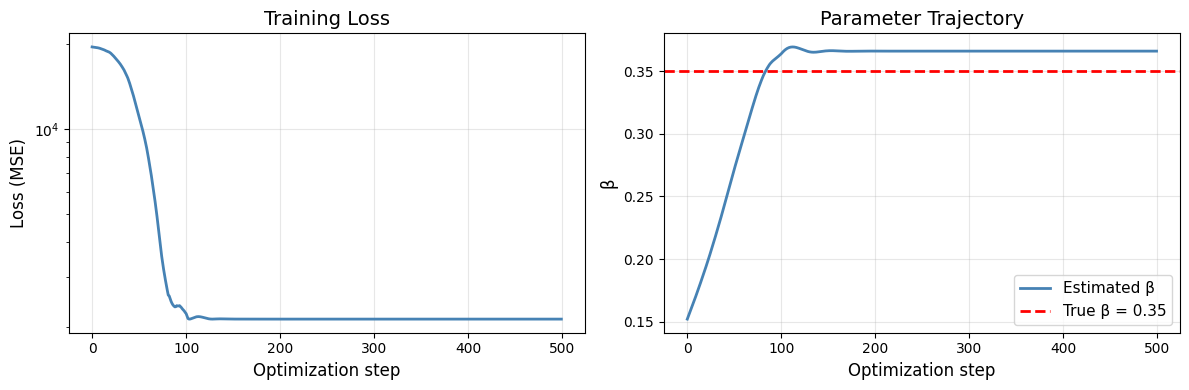

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax = axes[0]
ax.plot(history["loss"], color="steelblue", linewidth=2)
ax.set_xlabel("Optimization step", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Training Loss", fontsize=14)
ax.set_yscale("log")
ax.grid(alpha=0.3)

# Parameter trajectory
ax = axes[1]
ax.plot(history["params"], color="steelblue", linewidth=2, label="Estimated β")
ax.axhline(y=BETA_TRUE, color="red", linestyle="--", linewidth=2, label=f"True β = {BETA_TRUE}")
ax.set_xlabel("Optimization step", fontsize=12)
ax.set_ylabel("β", fontsize=12)
ax.set_title("Parameter Trajectory", fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 4: Compare Fitted vs True Model

Finally, let's compare the epidemic curves from:
- The **true** model (β = 0.35) - shown as observed data
- The **fitted** model (β ≈ estimated value) - run with multiple replicates
- The **initial** model (β = 0.15) - run with multiple replicates

We use `hard=True` for these simulations to get realistic discrete trajectories, and run multiple replicates to show the stochastic variability. The `run_diff_sir_replicates` function uses `vmap` for fast parallel execution.

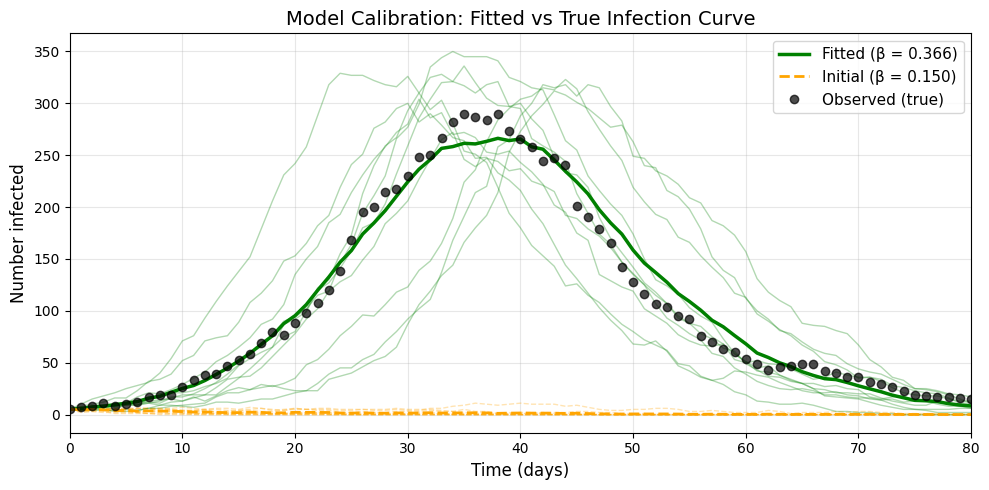

: 

In [ ]:
# Import the fast replicate utility
from emidm.diff import run_diff_sir_replicates

# Number of replicates for visualization
N_VIZ_REPS = 10

# Generate predictions with fitted and initial parameters using replicates
# This uses vmap for fast parallel execution
pred_fitted = run_diff_sir_replicates(
    N=N, I0=I0, beta=beta_hat, gamma=GAMMA, T=T,
    reps=N_VIZ_REPS, seed=0,
    config=DiffConfig(tau=0.1, hard=True),
)

pred_initial = run_diff_sir_replicates(
    N=N, I0=I0, beta=beta_init, gamma=GAMMA, T=T,
    reps=N_VIZ_REPS, seed=0,
    config=DiffConfig(tau=0.1, hard=True),
)

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
t = jnp.arange(T + 1)

# Plot replicates with transparency
for i in range(N_VIZ_REPS):
    ax.plot(t, pred_fitted["I"][i], "-", color="green", linewidth=1, alpha=0.3)
    ax.plot(t, pred_initial["I"][i], "--", color="orange", linewidth=1, alpha=0.3)

# Plot means
ax.plot(t, jnp.mean(pred_fitted["I"], axis=0), "-", color="green", linewidth=2.5, 
        label=f"Fitted (β = {float(beta_hat):.3f})")
ax.plot(t, jnp.mean(pred_initial["I"], axis=0), "--", color="orange", linewidth=2, 
        label=f"Initial (β = {float(beta_init):.3f})")

# Plot observed data
ax.plot(t, observed_I, "o", color="black", markersize=6, label="Observed (true)", alpha=0.7)
ax.set_xlabel("Time (days)", fontsize=12)
ax.set_ylabel("Number infected", fontsize=12)
ax.set_title("Model Calibration: Fitted vs True Infection Curve", fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim(0, T)
plt.tight_layout()
plt.show()

## Summary

In this tutorial, we demonstrated:

1. **Differentiable simulation**: Using `run_diff_sir` to simulate epidemics with gradients
2. **Gradient-based calibration**: Using `optimize_params` to fit model parameters
3. **Model comparison**: Visualizing how well the fitted model recovers the true dynamics

The key advantage of differentiable models is that we can use efficient gradient-based optimization instead of slower derivative-free methods (like grid search or MCMC). This becomes especially important for:

- **High-dimensional parameter spaces**: When fitting many parameters simultaneously
- **Complex models**: Where each simulation is computationally expensive
- **Uncertainty quantification**: Combining with variational inference or Hamiltonian Monte Carlo

See the [API documentation](https://ojwatson.github.io/emidm/api.html) for more details on the available models and utilities.

## A Note on Stochasticity

You may notice that the fitted β does not exactly match the true β used to generate the data. This is expected! The "observed" data we calibrated against was a **single stochastic realization** of the epidemic process. Due to random chance, this particular trajectory may have evolved slightly faster or slower than the average behavior for that β value.

When we fit the model, we find the β that best explains *this specific trajectory*, not the underlying true parameter. This is a fundamental limitation of point estimation from stochastic data.

In practice, to properly quantify parameter uncertainty and account for observation noise, we would use **Bayesian inference** methods. See the [Bayesian Inference tutorial](bayesian_inference.ipynb) for how to use differentiable models with Hamiltonian Monte Carlo (HMC) to obtain full posterior distributions over parameters.